## 1: Setup and Installs

First, we'll install the necessary libraries like transformers for the ViT model and scikit-learn for our data splitting and evaluation metrics. We'll also import everything we'll need.

In [ ]:
#!pip install keras-cv --quiet
#!pip install transformers --quiet
#!pip install scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.7 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from transformers import TFViTModel, ViTConfig
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import keras_cv
import seaborn as sns

print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

2025-11-16 06:29:39.024379: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 06:29:39.074327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-16 06:29:39.074355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-16 06:29:39.075608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-16 06:29:39.083625: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend
TensorFlow Version: 2.15.0
Num GPUs Available: 1


## 2: Configuration
Here, we set up all our project-specific variables. This includes your PROJECT_ID, the BUCKET_NAME, he specific ViT model (MODEL_CHECKPOINT). The required image size is dynamically retrieved from this model's configuration for consistency."

In [2]:
# --- 2. Configuration ---
PROJECT_ID = "mobily-genai"

# Set the project
!gcloud config set project {PROJECT_ID}
print(f"Project set to {PROJECT_ID}")

# Dataset and Model Configuration
BUCKET_NAME = "visualiq-raw-dataset"
BASE_GCS_PATH = f"gs://{BUCKET_NAME}/dataset"
MODEL_CHECKPOINT = "google/vit-base-patch32-224-in21k"

# Get image dimensions from the model config
config = ViTConfig.from_pretrained(MODEL_CHECKPOINT)
IMG_HEIGHT = config.image_size
IMG_WIDTH = config.image_size
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32

# Define class names and labels
# We'll use 0 for "bad" (the minority class) and 1 for "good"
CLASS_NAMES = ["bad", "good"]
LABEL_MAP = {"bad": 0, "good": 1}
# Invert map for lookups
LABEL_LOOKUP = {v: k for k, v in LABEL_MAP.items()}

print(f"Using Image Size: {IMG_SIZE}")
print(f"Base GCS Path: {BASE_GCS_PATH}")
print(f"Model Checkpoint: {MODEL_CHECKPOINT}")

Updated property [core/project].
Project set to mobily-genai
Using Image Size: (224, 224)
Base GCS Path: gs://visualiq-raw-dataset/dataset
Model Checkpoint: google/vit-base-patch32-224-in21k


## 3: Load Data Filepaths
In this step, we use TensorFlow's GCS tools (tf.io.gfile.glob) to scan our GCS bucket for all the images in the "bad" and "good" folders. We don't load the images yet—just their paths. We put these paths and their corresponding labels into a Pandas DataFrame, shuffle it, and add the integer labels (0 or 1).

In [3]:
# --- 3. Load Data Filepaths from GCS ---
print("\nLoading file paths from GCS...")
# Use tf.io.gfile.glob to scan GCS
bad_images = tf.io.gfile.glob(f"{BASE_GCS_PATH}/bad/*")
good_images = tf.io.gfile.glob(f"{BASE_GCS_PATH}/good/*")

print(f"Found {len(bad_images)} 'bad' images.")
print(f"Found {len(good_images)} 'good' images.")

# Create a Pandas DataFrame
bad_df = pd.DataFrame({"filepath": bad_images, "label_name": "bad"})
good_df = pd.DataFrame({"filepath": good_images, "label_name": "good"})

# Combine and shuffle the dataframe
df = pd.concat([bad_df, good_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add the integer label
df["label"] = df["label_name"].map(LABEL_MAP)

print("\n--- Initial Dataset Analysis ---")
print(df['label_name'].value_counts())
print(f"\nTotal images: {len(df)}")


Loading file paths from GCS...
Found 226 'bad' images.
Found 694 'good' images.

--- Initial Dataset Analysis ---
label_name
good    694
bad     226
Name: count, dtype: int64

Total images: 920


## 4: Create Train, Validation, and Test Splits
Before we do any augmentation or balancing, we split our raw data. We'll create a 80% Train, 10% Validation, and 10% Test split.

We use stratify=df["label"] to ensure that the original percentage of "bad" and "good" images is the same in all three splits.

In [4]:
# --- 4. Create Train, Validation, and Test Splits ---
print("\nSplitting data...")

# We'll aim for a 80% / 10% / 10% split
# Step 1: Split into Train+Val (90%) and Test (10%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    stratify=df["label"]
)

# Step 2: Split Train+Val (90%) into Train (80%) and Validation (10%)
# We need to find what fraction 10% is of 90%.
# The correct test_size is (10% / 90%) = 1/9 = 0.1111...
train_df, val_df = train_test_split(
    train_val_df,
    test_size=1/9,  # This is the correction: 0.10 / 0.90
    random_state=42,
    stratify=train_val_df["label"]
)

print(f"\nTotal training images:   {len(train_df)} ({len(train_df)/len(df):.0%})")
print(f"Total validation images: {len(val_df)} ({len(val_df)/len(df):.0%})")
print(f"Total test images:       {len(test_df)} ({len(test_df)/len(df):.0%})")

print("\n--- Training Set Distribution ---")
print(train_df['label_name'].value_counts(normalize=True))
print("\n--- Validation Set Distribution ---")
print(val_df['label_name'].value_counts(normalize=True))
print("\n--- Test Set Distribution ---")
print(test_df['label_name'].value_counts(normalize=True))


Splitting data...

Total training images:   736 (80%)
Total validation images: 92 (10%)
Total test images:       92 (10%)

--- Training Set Distribution ---
label_name
good    0.755435
bad     0.244565
Name: proportion, dtype: float64

--- Validation Set Distribution ---
label_name
good    0.75
bad     0.25
Name: proportion, dtype: float64

--- Test Set Distribution ---
label_name
good    0.75
bad     0.25
Name: proportion, dtype: float64


## 5: Define On-the-Fly Augmentation
Here, we define our augmentation pipeline using Keras layers. This Sequential model will perform random flips, rotations, and color adjustments. This will only be applied to our training set, during training.

In [5]:
# --- 5. Define On-the-Fly Augmentation Pipeline ---
# This will be applied ONLY to the training dataset
# Keras factor is a fraction of 360 degrees: 15 / 360
rotation_factor = 15 / 360  # This is 0.04167

# Random brightness of -15% to +15%
# Keras factor is the percentage: 0.15
brightness_factor = 0.15

#  Random Gaussian blur of 0 to 0.5 sigma
# tfa.layers.RandomGaussianBlur 'factor' is the max sigma.
blur_factor_range = (0.0, 0.5)

# --- Define the pipeline variable ---

data_augmentation_pipeline = tf.keras.Sequential(
    [
        #  50% prob for horizontal AND vertical
        layers.RandomFlip("horizontal_and_vertical"),

        #  Random rotation of -15 to +15 degrees
        layers.RandomRotation(rotation_factor),

        #  Random brightness of -15% to +15%
        layers.RandomBrightness(brightness_factor),

        # Random Gaussian blur of 0 to 0.5 sigma
        keras_cv.layers.RandomGaussianBlur(
            kernel_size=3, # A small kernel is standard
            factor=blur_factor_range
        )
    ],
    name="data_augmentation",
)

print("Data augmentation pipeline created.")

Data augmentation pipeline created.


2025-11-16 06:29:55.081269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1096 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


## 6: Create tf.data Helper Functions
To create an efficient data pipeline, we'll make two helper functions:



1. `parse_image` **Image Preprocessor**:
This function handles the necessary transformations for a single image. It reads the raw file, decodes it into a pixel tensor, fixes the tensor's shape to prevent graph errors, converts the image to float format, and resizes it to the ViT's required dimensions **(224x224)**. Finally, it scales the pixel values to the $\mathbf{[0, 255]}$ float range, ready for the final normalization step by the model's first layer.

2.  `create_dataset` **Pipeline Orchestrator:** This function takes a DataFrame and converts it into a tf.data.Dataset. It uses our parse_image function, shuffles the data, applies our augmentation pipeline, and sets up batching and prefetching.

In [6]:
# --- 6. Create tf.data.Dataset Helper Functions  ---

def parse_image(filepath, label):
    """Loads, preprocesses, and resizes a single image."""

    # 1. Read and Decode: returns (shape=(?, ?, 3))
    image = tf.io.read_file(filepath)
    image = tf.image.decode_image(image, channels=3)

    # 2. Explicitly set the rank/channel structure (rank=3).
    # This is necessary for tf.image.resize to work inside the tf.data graph.
    image.set_shape([None, None, 3])

    # 3. Convert to float32 before resizing (standard practice)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # 4. Resize: (shape=(H, W, 3))
    image = tf.image.resize(image, IMG_SIZE)

    # 5. Convert to [0, 255] float range
    # This prepares the data to be correctly normalized by the ViTClassifier's Rescaling layer.
    image = image * 255.0

    # 6. Final Shape Fix: Ensure the *resized* shape is fixed for final batching
    image.set_shape(IMG_SIZE + (3,))

    return image, label

def create_dataset(df, is_training=True, apply_augmentation=False):
    """Creates a tf.data.Dataset from a DataFrame."""
    # Create a tf.data.Dataset from the DataFrame
    dataset = tf.data.Dataset.from_tensor_slices((df["filepath"].values, df["label"].values))

    # Parse the images
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        # Shuffle the data
        dataset = dataset.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

        dataset = dataset.repeat() # Repeat indefinitely

    if apply_augmentation:
        # Apply on-the-fly augmentations
        dataset = dataset.map(
            lambda x, y: (data_augmentation_pipeline(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch and prefetch
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

print("tf.data helper functions defined and fixed.")

tf.data helper functions defined and fixed.


## 7: Create Datasets (with Weighted Sampler)


1.   We create two separate training datasets: one for "bad" images (ds_bad) and one for "good" images (ds_good). We tell the `create_dataset` function to apply augmentation to both.
2.   We use `tf.data.Dataset.sample_from_datasets` to combine them. By setting `weights=[0.5, 0.5]`, we're telling TensorFlow: "For every batch, pull 50% of the data from the 'bad' set and 50% from the 'good' set." This creates our balanced training dataset.
3.   We also create our standard, unbalanced validation and test datasets. These do not use augmentation or the sampler.

In [7]:
# --- 7. Create Datasets (with Weighted Sampler) ---
print("\nCreating datasets...")

# Create two separate datasets (with augmentation)
ds_bad = create_dataset(train_df[train_df.label == 0], is_training=True, apply_augmentation=True)
ds_good = create_dataset(train_df[train_df.label == 1], is_training=True, apply_augmentation=True)

# Create the balanced training dataset
# This tells TensorFlow to pull 50% of batches from ds_bad and 50% from ds_good
train_ds = tf.data.Dataset.sample_from_datasets(
    [ds_bad, ds_good],
    weights=[0.5, 0.5],
    seed=43 # add a seed for reproducibility
)

# Create standard (unbalanced) validation and test datasets
# No shuffling (at this stage) or augmentation needed
val_ds = create_dataset(val_df, is_training=False, apply_augmentation=False)
test_ds = create_dataset(test_df, is_training=False, apply_augmentation=False)

print("Datasets created successfully.")
print("Training dataset is now balanced via weighted sampling.")


Creating datasets...
Datasets created successfully.
Training dataset is now balanced via weighted sampling.


## 8: Build the ViT Model
Now we define a function to build our model. It does the following:


1.   Loads the pre-trained TFViTModel from Hugging Face.
2.   Freezes the pre-trained layers by setting vit_model.trainable = False.
3.   Passes the input through the ViT model.
4.   Pools the output by taking the [CLS] token (which is at index 0).
5.   Adds a new, trainable classification "output layer" on top for our binary (bad/good) problem.

In [8]:
# --- 1. Define the model as a new Keras Model class ---
class ViTClassifier(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # --- A. Define all the layers you will need ---
        self.rescaling = tf.keras.layers.Rescaling(1./127.5, offset=-1)
        # Pre-processing layer
        # We go from (Batch, H, W, C) to (Batch, C, H, W)
        self.permute = tf.keras.layers.Permute((3, 1, 2))

        # The Hugging Face ViT base model
        hub_id = "google/vit-base-patch16-224-in21k"
        self.vit_base = TFViTModel.from_pretrained(
            hub_id,
            trainable=False, # Start with frozen weights
            from_pt=True     # Force PyTorch -> TF conversion
        )

        # Your classifier layers
        self.dense_1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid') # For binary classification

    # --- B. Define the forward pass (how data flows) ---
    def call(self, inputs):
        # 1. Pre-process the inputs
        # 'inputs' are already normalized to [-1, 1] by the tf.data pipeline
        # All we need to do is permute the dimensions
        x = self.rescaling(inputs) # STEP 1: Normalize [0, 255] -> [-1, 1]
        x = self.permute(x)

        # 2. Get outputs from the base model
        outputs = self.vit_base(x)

        # 3. Get the [CLS] token (the first token)
        # This is the summary vector for the entire image
        cls_token = outputs.last_hidden_state[:, 0, :]

        # 4. Pass through your classifier
        x = self.dense_1(cls_token)
        x = self.dropout(x)
        return self.output_layer(x)

print("ViTClassifier class defined successfully.")

ViTClassifier class defined successfully.


In [10]:
print("Creating an instance of the ViTClassifier...")

# --- 2. Create an instance of the model ---
model = ViTClassifier()

Creating an instance of the ViTClassifier...


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


## 9: Compile the Model
With the model built, we compile it.

*   Optimizer: Adam.
*   Loss: binary_crossentropy is the loss function for a two-class problem with a sigmoid activation.
*   Metrics: Precision and Recall in addition to accuracy.

In [13]:
# --- 9. Compile the Model ---
print("\nCompiling model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # 0.0001
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)
print("Model compiled.")


Compiling model...
Model compiled.


## 10: Train the Model
It's time to train! We call model.fit, passing our balanced train_ds and our unbalanced val_ds. We also add an EarlyStopping callback, which will automatically stop training if the validation accuracy (val_accuracy) doesn't improve for 5 epochs in a row, and it will restore the best weights it found.

In [14]:
# --- 10. Train the Model ---
print("\nStarting model training...")

EPOCHS = 50 # Start with a reasonable number
EPOCH_STEPS = 23 # required to cover 736 samples (736/32=23)
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=EPOCH_STEPS,
    validation_data=val_ds,
    callbacks=[
        # Stop if validation accuracy stops improving
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            restore_best_weights=True
        )
    ]
)

print("\nTraining complete.")


Starting model training...
Epoch 1/50


2025-11-12 13:22:19.831289: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdc4cd41950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 13:22:19.831326: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-11-12 13:22:19.841150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762953740.097494   79847 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/23 [>.............................] - ETA: 8:11 - loss: 0.7082 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-11-12 13:22:26.663819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:9,RepeatDataset:10): Filling up shuffle buffer (this may take a while): 307 of 556
2025-11-12 13:22:32.640206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


23/23 [==============================] - 61s 2s/step - loss: 0.6862 - accuracy: 0.5326 - precision: 0.4073 - recall: 0.4271 - val_loss: 0.6952 - val_accuracy: 0.4348 - val_precision: 0.9474 - val_recall: 0.2609
Epoch 2/50
23/23 [==============================] - 17s 749ms/step - loss: 0.6022 - accuracy: 0.7296 - precision: 0.6087 - recall: 0.3125 - val_loss: 0.7219 - val_accuracy: 0.3913 - val_precision: 0.9333 - val_recall: 0.2029
Epoch 3/50
23/23 [==============================] - 21s 933ms/step - loss: 0.5739 - accuracy: 0.7133 - precision: 0.7778 - recall: 0.2461 - val_loss: 0.7201 - val_accuracy: 0.4130 - val_precision: 1.0000 - val_recall: 0.2174
Epoch 4/50
23/23 [==============================] - 21s 946ms/step - loss: 0.6954 - accuracy: 0.5122 - precision: 0.8870 - recall: 0.3897 - val_loss: 0.5693 - val_accuracy: 0.8478 - val_precision: 0.9825 - val_recall: 0.8116
Epoch 5/50
23/23 [==============================] - 17s 773ms/step - loss: 0.5530 - accuracy: 0.7880 - precision: 

## 11: Evaluate on Test Set
After training, we perform our final evaluation on the unseen, test set. This gives us the most realistic measure of how our model will perform in the real world.

In [15]:
# --- 11. Evaluate the Model on the Test Set ---
print("\nEvaluating model on the test set...")
results = model.evaluate(test_ds, verbose=0)

print("\n--- Test Set Performance ---")
print(f"Test Loss:     {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall:    {results[3]:.4f}")


Evaluating model on the test set...

--- Test Set Performance ---
Test Loss:     0.4676
Test Accuracy: 0.8261
Test Precision: 0.9344
Test Recall:    0.8261


## 12: Plot confusion matrix

To visualize the model's performance beyond scalar metrics, we define a helper function, plot_confusion_matrix. This function iterates through the dataset to collect the true labels and model predictions, computes the standard confusion matrix using scikit-learn, and visualizes the result as a heatmap using Seaborn. This visualization is crucial for understanding specific error types (False Positives and False Negatives).

In [ ]:
def plot_confusion_matrix(model, dataset, class_names=None):
    """
    Computes and plots a confusion matrix for a given model and dataset.

    Args:
        model (tf.keras.Model): The trained Keras model.
        dataset (tf.data.Dataset): The dataset to evaluate (e.g., val_ds or test_ds).
        class_names (list of str, optional): Names for the classes (e.g., ['Class 0', 'Class 1']).
                                             Defaults to [0, 1] if not provided.
    """

    print("Gathering true labels and predictions...")

    # 1. Get all true labels from the dataset
    # This iterates through the dataset and extracts all 'y' batches
    y_true = np.concatenate([y for x, y in dataset], axis=0)

    # 2. Get all predictions from the model
    # model.predict() is highly efficient and runs on the full dataset
    y_pred_probs = model.predict(dataset)

    # 3. Convert probabilities to class labels (0 or 1)
    # We use a 0.5 threshold for this
    y_pred = (y_pred_probs.squeeze() > 0.5).astype(int)

    print(f"Total samples: {len(y_true)}")

    # 4. Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # 5. Plot the confusion matrix using Seaborn
    if class_names is None:
        class_names = [0, 1]

    plt.figure(figsize=(8, 6))

    # Create the heatmap
    sns.heatmap(
        cm,
        annot=True,     # Show the numbers in each cell
        fmt="d",        # Format as integers
        cmap="Blues",   # Color scheme
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title("Confusion Matrix", fontsize=16)
    plt.ylabel("True Label", fontsize=12)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.show()

Calling the plot_confusion_matrix function...
Gathering true labels and predictions...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step
Total samples: 92


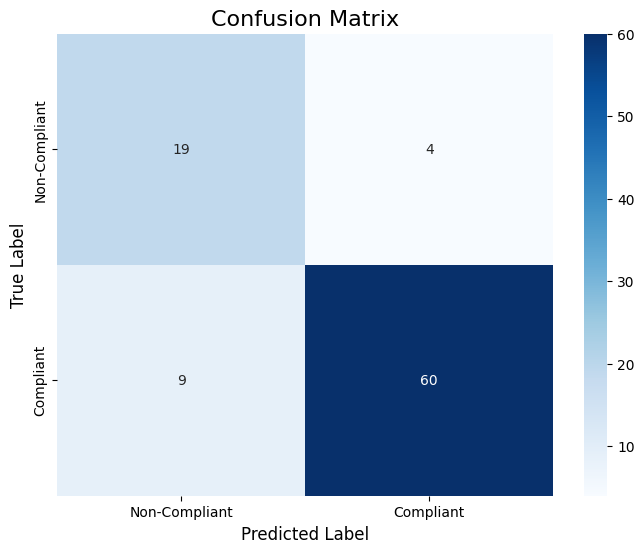

In [ ]:
# --- 13. Plot Confusion Matrix ---
# This command CALLS the function you defined and actually
# runs the code to make the plot.

print("Calling the plot_confusion_matrix function...")

plot_confusion_matrix(
    model=model,      # This is your trained model
    dataset=test_ds,  # This is your test dataset
    class_names=['Non-Compliant', 'Compliant']
)

## 13: Training and validation loss and accuracy plots

After training is complete, this step plots the loss and accuracy curves for both the training and validation datasets across all epochs. This helps visualize training stability and identify signs of overfitting.

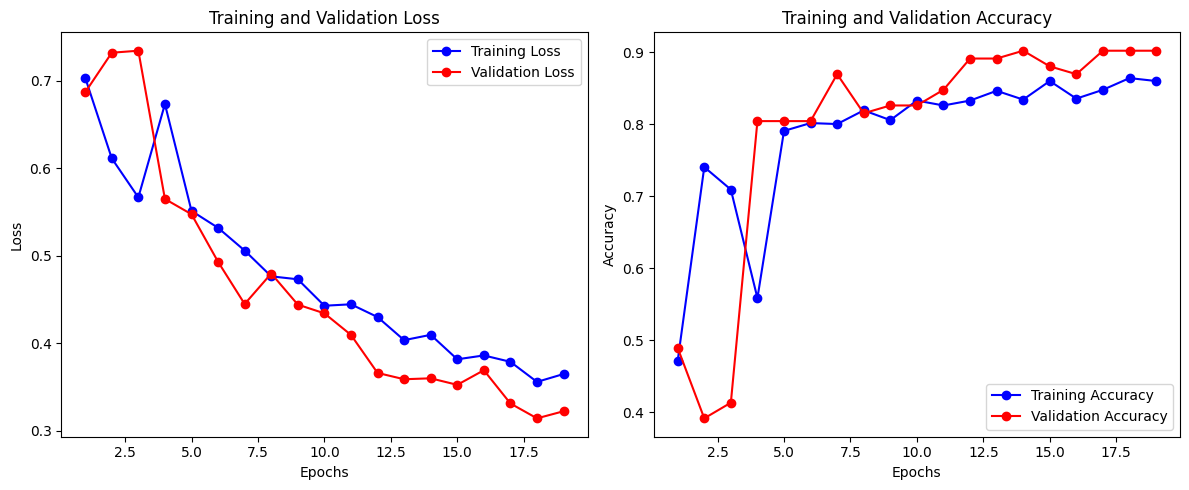

In [ ]:
# The 'history' object was returned by model.fit()
history_dict = history.history

# Get the loss and accuracy from the history object
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(loss_values) + 1)

# Plot 1: Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

## 14: Evaluation Metrics by ODB Box Type

This section sets up and executes a detailed, specialized analysis to determine how the model performs on different categories of (ODB Box Types). By calculating metrics for each box type individually, we can pinpoint where the model is performing strongly and where further training or data collection may be needed.

### 14.1: Extract the test dataset

This code prepares a template CSV file containing the file paths and true labels of the test set. The file is saved to GCS so that it can later be labeled with the 'ODB_Type' (Optical Distribution Box Type) for specialized analysis.

In [ ]:
# --- 1. Define GCS Output Path ---
# Ensure this matches your project's configuration
BUCKET_NAME = "visualiq-splitted-dataset"
GCS_OUTPUT_DIR = f"gs://{BUCKET_NAME}/dataset-splits"

# --- 2. Create the Final Labeling Template ---
print("\n--- Creating Final Labeling Template ---")

# Start with a copy of the test_df
labeling_template_df = test_df.copy()

# Add a simple index column that matches the model's prediction order
labeling_template_df['Prediction_Index'] = range(len(test_df))

# Rename key columns for clarity
labeling_template_df = labeling_template_df.rename(columns={
    'filepath': 'GCS_File_Path',
    'label_name': 'True_Label_Name'
})

# Filter the DataFrame to contain only the necessary columns
labeling_template_df = labeling_template_df[['Prediction_Index', 'GCS_File_Path', 'True_Label_Name']]

# Add the placeholder column for the user to fill manually
labeling_template_df['ODB_Type'] = 'FILL_IN'

# --- 3. Save the Template to GCS as a Clean CSV ---
gcs_template_path = os.path.join(GCS_OUTPUT_DIR, 'test_labeling_template_clean.csv')
labeling_template_df.to_csv(gcs_template_path, index=False)

print(f"Clean Labeling Template saved to: {gcs_template_path}")
print("\nPlease download this CSV, fill in the 'ODB_Type' column, and re-upload it.")

# Display a preview
print("\n--- Template Preview ---")
print(labeling_template_df.head())


--- Creating Final Labeling Template ---
Clean Labeling Template saved to: gs://mobily-visualiq-augmented-dataset/dataset-splits/test_labeling_template_clean.csv

Please download this CSV, fill in the 'ODB_Type' column, and re-upload it.

--- Template Preview ---
     Prediction_Index                                      GCS_File_Path  \
685                 0  gs://mobily-visualiq-raw-dataset/dataset/good/...   
9                   1  gs://mobily-visualiq-raw-dataset/dataset/bad/2...   
89                  2  gs://mobily-visualiq-raw-dataset/dataset/bad/P...   
831                 3  gs://mobily-visualiq-raw-dataset/dataset/good/...   
69                  4  gs://mobily-visualiq-raw-dataset/dataset/good/...   

    True_Label_Name ODB_Type  
685            good  FILL_IN  
9               bad  FILL_IN  
89              bad  FILL_IN  
831            good  FILL_IN  
69             good  FILL_IN  


### 14.2: Get the prediction label and actuall label

This step runs the trained model against the entire test dataset to generate the final predictions. It collects both the model's binary predictions (y_pred) and the ground truth labels (y_true), preparing them for metric calculation in the next step.

In [ ]:
print("--- Recalculating Predictions and True Labels ---")

# 1. Get the Raw Predictions (Scores) from the test set
raw_predictions = model.predict(test_ds)

# 2. Convert Raw Scores to Binary Labels (y_pred)
# Use the standard 0.5 threshold
y_pred = (raw_predictions > 0.5).astype(int)

# 3. Extract the Ground Truth Labels (y_true) from the test set
y_true = []
for images, labels in test_ds:
    # We only need the labels (the 'y' part of the dataset tuple)
    y_true.extend(labels.numpy())

# Convert the list of true labels to a numpy array
y_true = np.array(y_true)

print(f"y_true has {len(y_true)} samples.")
print(f"y_pred has {len(y_pred)} samples.")
print("y_true and y_pred are now defined and ready for analysis.")

--- Recalculating Predictions and True Labels ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step
y_true has 92 samples.
y_pred has 92 samples.
y_true and y_pred are now defined and ready for analysis.


### 14.3: Print the Evaluation Metrics by ODB Box Type

This is the final and most detailed evaluation step. It loads the labeled 'ODB_Type' data from GCS and calculates the key performance metrics (Accuracy, Precision, and Recall) separately for each specific ODB box type. This helps pinpoint where the model performs best and worst.

In [ ]:
GCS_LABELS_PATH = "gs://mobily-visualiq-augmented-dataset/dataset-splits_test_labeling_template_clean_labled.csv"

# --- 1. Load the ODB Types from GCS ---
try:
    labels_df = pd.read_csv(GCS_LABELS_PATH)

    # Assuming your completed column is named 'ODB_Type'
    odb_box_types = labels_df['ODB_Type'].values

except Exception as e:
    print(f"ERROR reading GCS file: {e}")
    print(f"Please verify the file path: {GCS_LABELS_PATH}")
    raise # Stop execution if file cannot be read

# --- 2. Combine the data with Predictions ---
# Assumes y_true and y_pred are available from your previous successful prediction step
if len(odb_box_types) != len(y_true):
    raise ValueError(f"ODB Box Types list size ({len(odb_box_types)}) does not match y_true size ({len(y_true)}).")

results_df = pd.DataFrame({
    'y_true': y_true.flatten(),
    'y_pred': y_pred.flatten(),
    'odb_type': odb_box_types
})

# --- 3. Evaluate Full Metrics for Each Unique ODB Box Type ---
print("\n--- Evaluation Metrics by ODB Box Type ---")
class_names = ['Non-Compliant', 'Compliant'] # Compliant is the positive class

for box_type in results_df['odb_type'].unique():
    # Filter the DataFrame for the current box type
    subset = results_df[results_df['odb_type'] == box_type]

    # Calculate Overall Accuracy
    acc = accuracy_score(subset['y_true'], subset['y_pred'])

    # Calculate Precision and Recall for the positive class ('Compliant')
    # Use labels=[0, 1] to ensure classification_report doesn't fail on small subsets
    report = classification_report(
        subset['y_true'],
        subset['y_pred'],
        labels=[0, 1],
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Extract metrics for the positive class (Compliant)
    pos_precision = report['Compliant']['precision']
    pos_recall = report['Compliant']['recall']
    n_samples = len(subset)

    print(f"\n=========================================")
    print(f"ODB Box Type: {box_type} (N={n_samples})")
    print(f"=========================================")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {pos_precision:.4f}")
    print(f"Recall: {pos_recall:.4f}")

print("\n--- Analysis Complete ---")


--- Evaluation Metrics by ODB Box Type ---

ODB Box Type: C (N=62)
Accuracy: 0.8548
Precision: 0.9512
Recall: 0.8478

ODB Box Type: D (N=13)
Accuracy: 0.7692
Precision: 0.7143
Recall: 0.8333

ODB Box Type: B (N=8)
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000

ODB Box Type: A (N=9)
Accuracy: 0.8889
Precision: 1.0000
Recall: 0.8889

--- Analysis Complete ---


### 15: Saving the model in Google Cloud Storage (GCS)
The final trained model is exported and saved to a specified location in Google Cloud Storage (GCS) in the SavedModel format. This makes the model ready for deployment or future inference tasks.

In [16]:
MODEL_SAVE_PATH = f"gs://visualiq-models/models/visualiq-vit-base-model-v1" # New name

print(f"\n--- Exporting ViT model in SavedModel format to {MODEL_SAVE_PATH} ---")

# Use model.export() to save in the SavedModel directory format
model.export(MODEL_SAVE_PATH)

print("Model exported successfully in SavedModel format!")

# Optional: List the contents of the GCS directory to verify
print("\n--- Verifying contents in GCS ---")
!gsutil ls {MODEL_SAVE_PATH}/


--- Exporting ViT model in SavedModel format to gs://visualiq-models/models/visualiq-vit-base-model-v1 ---
Saved artifact at 'gs://visualiq-models/models/visualiq-vit-base-model-v1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140561398427392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398426160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398420352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398423872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398717376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398714736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398429504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140561398426688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1405613984296

### 16: Save the dataset split
This final step ensures that the exact file lists used for the training, validation, and test splits (train_df, val_df, test_df) are permanently saved as CSV files in GCS. This guarantees that the experiment is reproducible and fully traceable.

In [ ]:
# --- 1. Define GCS Output Base Path ---
# Replace BUCKET_NAME with your bucket if it's different
BUCKET_NAME = "visualiq-splitted-dataset"
GCS_BASE_SPLIT_DIR = f"gs://{BUCKET_NAME}/split" # Base folder for all splits

# --- 2. Save Each DataFrame to its Dedicated Folder ---
print("\n--- Saving Split DataFrames to Structured GCS Paths ---")

# Save Training Set
train_dir = os.path.join(GCS_BASE_SPLIT_DIR, 'train')
train_gcs_path = os.path.join(train_dir, 'train_split.csv')
train_df.to_csv(train_gcs_path, index=False)
print(f"Train DataFrame saved to: {train_gcs_path}")

# Save Validation Set
valid_dir = os.path.join(GCS_BASE_SPLIT_DIR, 'valid')
val_gcs_path = os.path.join(valid_dir, 'valid_split.csv')
val_df.to_csv(val_gcs_path, index=False)
print(f"Validation DataFrame saved to: {val_gcs_path}")

# Save Test Set
test_dir = os.path.join(GCS_BASE_SPLIT_DIR, 'test')
test_gcs_path = os.path.join(test_dir, 'test_split.csv')
test_df.to_csv(test_gcs_path, index=False)
print(f"Test DataFrame saved to: {test_gcs_path}")

print("\nAll split DataFrames successfully saved to GCS.")


--- Saving Split DataFrames to Structured GCS Paths ---
Train DataFrame saved to: gs://mobily-visualiq-augmented-dataset/model-runs/split/train/train_split.csv
Validation DataFrame saved to: gs://mobily-visualiq-augmented-dataset/model-runs/split/valid/valid_split.csv
Test DataFrame saved to: gs://mobily-visualiq-augmented-dataset/model-runs/split/test/test_split.csv

All split DataFrames successfully saved to GCS.
